In [1]:
import numpy as np
import pandas as pd
import torch
from permetrics import RegressionMetric

from experiment_runner import (
    ControlConfig,
    ProposedMethodConfig,
    run_comparison_experiments,
)
from svd_based_optimizer import SvdOptimizer
from ols_optimizer import OlsOptimizer
import matplotlib.pyplot as plt
from dimension_estimation import estimate_dimension, OptimalDimensionSelectionMethod, CaoEstimator
from lag_estimation import estimate_tau, OptimalLagSelectionMethod, AmiEstimator

## Loading the dataset

In [2]:
# dataset = pd.read_csv(r".\data\SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
dataset = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/lynx.csv',
                   index_col=0)
dataset.set_index('time', inplace=True)
dataset.head()

,value
time,
1821,269
1822,321
1823,585
1824,871
1825,1475


In [3]:
dataset.describe()

,value
count,114.000000
mean,1538.017544
std,1585.843914
min,39.000000
25%,348.250000
50%,771.000000
75%,2566.750000
max,6991.000000


In [53]:
# time_series = dataset['Value'].values
time_series = dataset['value'].values
time_series = time_series[np.nonzero(~np.isnan(time_series))]

In [56]:
# time_series_mu = np.mean(time_series)
# time_series_std = np.std(time_series)

# time_series = np.diff(time_series, prepend=time_series[0])
# time_series = (time_series - time_series_mu) / time_series_std
time_series = np.log10(time_series)

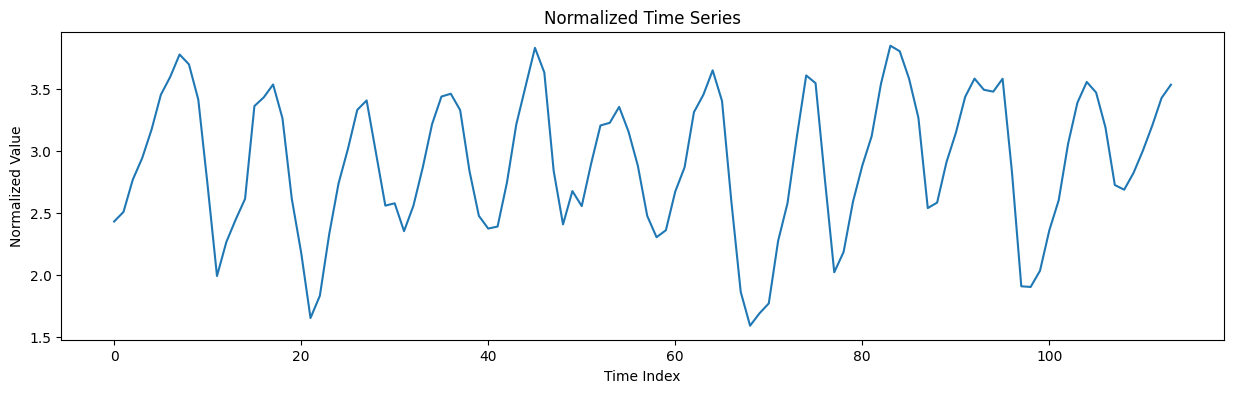

In [57]:
plt.figure(figsize=(15, 4))
plt.plot(time_series)
plt.title('Normalized Time Series')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.show()

## Estimating the embedding parameters

In [77]:
tau = estimate_tau(
    time_series,
    estimator=AmiEstimator(
        max_lag=20, optimum_selection_method=OptimalLagSelectionMethod.FIRST_LOC_MIN
    ),
)
print(f"Estimated tau: {tau}")

Estimated tau: 2


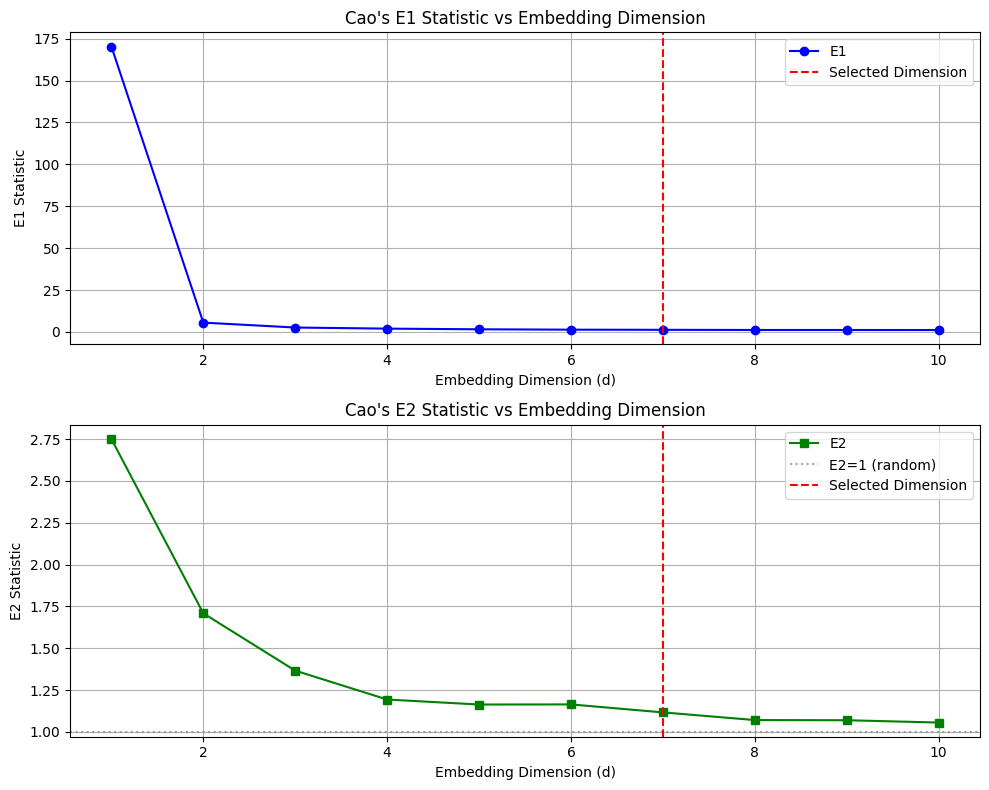

Estimated dimension: 7


In [78]:
dim = estimate_dimension(
    time_series,
    estimator=CaoEstimator(
        delay=tau,
        max_dim=10,
        optimum_selection_method=OptimalDimensionSelectionMethod.E1_E2_COMBINED,
        plot=True,
    ),
)
print(f"Estimated dimension: {dim}")

In [79]:
# dim = 2
# tau = 1

## Configuring the models

In [99]:
configs = [
    *[
        ProposedMethodConfig(
            approach="no_pretraining",
            optimizer=SvdOptimizer(epsilon=0.05, alpha=alpha),
            m=m,
            post_tune=post_tune,
            n=dim,
            embedding_tau=tau,
        )
        # for m in [2, 5, 10, 20, 30, 50, 100]
        for m in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        for alpha in [1e-4, 1e-2, 1e-1, 5e-1, 1, 2, 5]
        for post_tune in [True, False]
    ],
    *[
        ProposedMethodConfig(
            approach="pretraining",
            optimizer=OlsOptimizer(rho=rho),
            m=100,
            n=dim,
            embedding_tau=tau,
            post_tune=post_tune,
        )
        for rho in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
        for post_tune in [True, False]
    ],
]

control_configs = [
    ControlConfig(m=m, n=dim, embedding_tau=tau, lr=lr)
    for m in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    for lr in [1e-3, 1e-2, 1e-1]
]

In [100]:
proposed_results, control_results = run_comparison_experiments(
        time_series,
        configs,
        control_configs,
        train_ratio=0.75,
        device="cuda" if torch.cuda.is_available() else "cpu",
        run_parallel=False,
        show_progress=True,
    )

if not isinstance(proposed_results, list):
    proposed_results = [proposed_results]
if not isinstance(control_results, list):
    control_results = [control_results]

















































































Running Experiments: 100%|██████████| 184/184 [00:29<00:00,  6.18experiment/s]


In [101]:
results_df = pd.DataFrame(
    {
        "Type": [],
        "Name": [],
        "Test R": [],
        "Test R^2": [],
        "Test NRMSE": [],
    }
)

for res in proposed_results:
    test_metrics = RegressionMetric(
        y_pred=res.test_predictions,
        y_true=res.test_targets,
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Proposed"],
            "Name": [
                f"{res.method_name} (m={res.metadata['total_centers']}, alpha={res.metadata['optimizer_params']['_alpha']})" if res.metadata["optimizer_type"] == "SvdOptimizer" else
                f"{res.method_name} (|C|={res.metadata['selected_centers']}, rho={res.metadata['optimizer_params']['_rho']})"
            ],
            "Test R": [test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [test_metrics.R2()],
            "Test NRMSE": [test_metrics.normalized_root_mean_square_error()],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

for res in control_results:
    control_test_metrics = RegressionMetric(
        y_pred=res.test_predictions,
        y_true=res.test_targets,
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Control"],
            "Name": [f"Control (m={res.metadata['m_ctrl']})"],
            "Test R": [control_test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [control_test_metrics.R2()],
            "Test NRMSE": [control_test_metrics.normalized_root_mean_square_error()],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

In [102]:
PROPOSED_MODEL_SELECTION_CRITERION = "Test R^2"
PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = True

In [103]:
results_df.groupby("Type")[results_df.columns].apply(lambda x: x.sort_values(by=PROPOSED_MODEL_SELECTION_CRITERION, ascending=not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE).drop(columns=["Type"]).head(3))

Name    Test R  \
Type                                                                        
Control  159                                      Control (m=2)  0.653051   
         162                                      Control (m=3)  0.728267   
         158                                      Control (m=2)  0.644022   
Proposed 28   PROPOSED-no_pretraining-SvdOptimizer (m=3, alp...  0.782482   
         32   PROPOSED-no_pretraining-SvdOptimizer (m=3, alp...  0.741116   
         144  PROPOSED-pretraining-OlsOptimizer (|C|=20, rho...  0.814702   

              Test R^2  Test NRMSE  
Type                                
Control  159  0.259522    0.818471  
         162  0.101811    0.702963  
         158 -0.166212    0.985899  
Proposed 28   0.522607    0.802764  
         32   0.489765    0.830160  
         144  0.430852    0.581677

In [104]:
print(f"Best proposed model is: {results_df.sort_values(by=["Type", PROPOSED_MODEL_SELECTION_CRITERION], ascending=[False, not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE]).head(1)["Name"].values[0]}")

Best proposed model is: PROPOSED-no_pretraining-SvdOptimizer (m=3, alpha=0.0001)


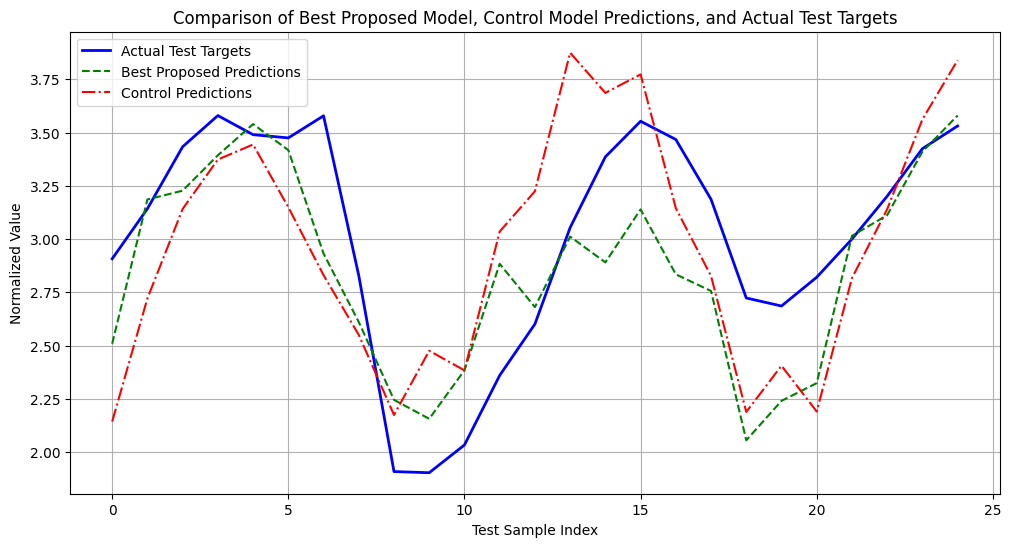

In [105]:
# Find the index of the best proposed model based on lowest Test NRMSE
best_proposed_idx = results_df[results_df["Type"] == "Proposed"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmax() if PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Proposed"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmin()
best_proposed_res = proposed_results[best_proposed_idx]

best_control_idx = results_df[results_df["Type"] == "Control"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmax() if PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Control"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmin()
best_control_res = control_results[best_control_idx - len(proposed_results)]

# Get test targets (actual values for test set)
test_targets = best_proposed_res.test_targets  # Assuming all have the same test_targets

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_targets, label="Actual Test Targets", color="blue", linewidth=2)
plt.plot(
    best_proposed_res.test_predictions,
    label=f'Best Proposed Predictions',
    color="green",
    linestyle="--",
)
plt.plot(
    best_control_res.test_predictions,
    label=f"Control Predictions",
    color="red",
    linestyle="-.",
)
plt.xlabel("Test Sample Index")
plt.ylabel("Normalized Value")
plt.title(
    "Comparison of Best Proposed Model, Control Model Predictions, and Actual Test Targets"
)
plt.legend()
plt.grid(True)
plt.show()